In [14]:
def make_impute_data(x, frac):
        temp = np.copy(x)
        for i in temp:
            n = np.random.choice(len(i), round(
                frac * len(i)), replace=False)
            i[n] = -1
        
        return temp

In [15]:
def assertions(self):
        global allowed_activations, allowed_noises, allowed_losses
        #assert self.loss in allowed_losses, 'Incorrect loss given'
        assert 'list' in str(
            type(self.dims)), 'dims must be a list even if there is one layer.'
        assert len(self.epoch) == len(
            self.dims), "No. of epochs must equal to no. of hidden layers"
        assert len(self.activations) == len(
            self.dims), "No. of activations must equal to no. of hidden layers"
        assert all(
            True if x > 0 else False
            for x in self.epoch), "No. of epoch must be atleast 1"
        assert set(self.activations + allowed_activations) == set(
            allowed_activations), "Incorrect activation given."
        assert utils.noise_validator(
            self.noise, allowed_noises), "Incorrect noise given"
        #assert self.impute is True and self.noise is None, "No noise provided for imputation"

In [16]:
import tensorflow as tf
import numpy as np
import math
import random


allowed_activations = ['sigmoid', 'tanh', 'softmax', 'relu', 'linear']
allowed_noises = [None, 'gaussian', 'mask']
allowed_losses = ['rmse', 'cross-entropy']


class DenoisingAutoEncoder:
    """A deep autoencoder with denoising capability"""



    def __init__(self, dims, activations, epoch=1000, noise=None, mask=0, impute=None, loss='rmse',
                 lr=0.001, batch_size=100, print_step=50, noise_value=0):
        self.print_step = print_step
        self.batch_size = batch_size
        self.lr = lr
        self.loss = loss
        self.activations = activations
        self.noise = noise
        self.epoch = epoch
        self.dims = dims
        #self.assertions()
        self.depth = len(dims)
        self.weights, self.biases = [], []
        self.decoded = []
        self.impute = impute
        self.data_to_impute = None
        self.decoded_biases = []
        self.decode_weights = []
        self.mask = mask
        self.noise_value = noise_value

    def add_noise(self, x, noise_value):
        if self.noise == 'gaussian':
            n = np.random.normal(0, 0.1, (len(x), len(x[0])))
            #self.noisy_data = x + n
            return x + n
        if 'mask' in self.noise:
            frac = float(self.noise.split('-')[1])
            temp = np.copy(x)
            for i in temp:
                n = np.random.choice(len(i), round(
                    frac * len(i)), replace=False)
                i[n] = noise_value
            #self.noisy_data = np.copy(x)
            return temp
        if self.noise == 'sp':
            pass
     
    
    def make_impute_data(self, x):
        frac = self.impute
        temp = np.copy(x)
        for i in temp:
            n = np.random.choice(len(i), round(
                frac * len(i)), replace=False)
            i[n] = -1
        self.noisy_data = np.copy(temp)
        
        return temp
    
    
    def fit_transform(self, data_x):
        decode = self.fit(data_x, self.dims, self.loss, self.lr, self.batch_size,\
                          self.activations, self.print_step, self.mask, self.epoch, self.noise_value)
        return decode

    
    def fit(self, data_x, dims, loss, lr, batch_size, activations, print_step, mask, epoch, noise_value):
        noisy_data = self.make_impute_data(data_x)
        n_rows = data_x.shape[0]
        tf.reset_default_graph()
        sess = tf.Session()
        x = tf.placeholder(dtype=tf.float32, shape=[None, len(data_x[0])], name='x')
        noisy_x = tf.placeholder(dtype=tf.float32, shape=[None, len(data_x[0])], name='noisy_x')
        learning_rate = tf.placeholder(tf.float32, shape=[])
        
        next_layer_input = noisy_x
        weights = []
        biases = []
        for dim, a in zip(dims, activations):
            #print dim, a
            input_dim = int(next_layer_input.get_shape()[1])
            
            np_noise = self.add_noise(np.ones((batch_size, input_dim)), self.noise_value)
            
            noise = tf.constant(np_noise, dtype=tf.float32)
            
            next_layer_input = next_layer_input * noise
            
            W = tf.Variable(tf.truncated_normal([input_dim, dim]))
            # Initialize b to zero
            b = tf.Variable(tf.truncated_normal([dim]))

            # We are going to use tied-weights so store the W matrix for later reference.
            weights.append(W)
            biases.append(b)

            output = self.activate((tf.matmul(next_layer_input,W) + b), a)

            # the input into the next layer is the output of this layer
            next_layer_input = output

        # The fully encoded x value is now stored in the next_layer_input
        encoded_x = next_layer_input

        # build the reconstruction layers by reversing the reductions
        dims.reverse()
        weights.reverse()
        activations.reverse()
        
        decoded_biases = []
        
        for i, dim in enumerate(dims[1:] + [ int(x.get_shape()[1])]) :
            # we are using tied weights, so just lookup the encoding matrix for this step and transpose it
            W = tf.transpose(weights[i])
            b = tf.Variable(tf.truncated_normal([dim]))
            decoded_biases.append(b)
            output = self.activate((tf.matmul(next_layer_input,W) + b), activations[i])
            next_layer_input = output
        
        reconstructed_x = next_layer_input
        
        if loss == 'rmse':
            loss = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(x, reconstructed_x))))
        elif loss == 'cross-entropy':
            loss = -tf.reduce_mean(x * tf.log(reconstructed_x))
        train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
        
        
        init = tf.initialize_all_variables()
        sess.run(init)
        
        lr_adapt_flag = True
        # do 1000 training steps
        for i in range(epoch):
            if i > epoch*3/4 and lr_adapt_flag:
                print( 'lr prev',lr)
                lr=lr/3.
                lr_adapt_flag=False
                print( 'lr new',lr)
            samp = np.random.randint(data_x.shape[0] ,size = batch_size)
            noisy_batch = noisy_data[samp,:]
            batch = data_x[samp,:]
            sess.run(train_step, feed_dict={x: np.array(batch), noisy_x: noisy_batch, learning_rate: lr})
            if i % print_step == 0:
                print (i, " cost", sess.run(loss, feed_dict={x: batch, noisy_x: noisy_batch}))
        
        for w, b, db in zip(weights, biases, decoded_biases):
            self.weights.append(w.eval(session=sess))
            self.biases.append(b.eval(session=sess))
            self.decoded_biases.append(db.eval(session=sess))
            
        self.weights.reverse()
        #self.biases.reverse()
        #return sess.run(reconstructed_x, feed_dict= {x : data_x})


    def transform(self, data):
        tf.reset_default_graph()
        sess = tf.Session()
        x_encoded = tf.constant(data, dtype=tf.float32)
        for w, b, a in zip(self.weights, self.biases, self.activations):
            weight = tf.constant(w, dtype=tf.float32)
            bias = tf.constant(b, dtype=tf.float32)
            layer = tf.matmul(x_encoded, weight) + bias
            x_encoded = self.activate(layer, a) 
        
        x_decoded = x_encoded
        for w, b, a in zip(self.weights[::-1], self.decoded_biases, self.activations[::-1]):
            weight = tf.transpose(tf.constant(w, dtype=tf.float32))
            bias = tf.constant(b, dtype=tf.float32)
            layer = tf.matmul(x_decoded, weight) + bias
            x_decoded = self.activate(layer, a)
            
        return {'encoded': x_encoded.eval(session=sess), 'decoded': x_decoded.eval(session=sess)}
        
    def activate(self, linear, name):
        if name == 'sigmoid':
            return tf.nn.sigmoid(linear, name='encoded')
        elif name == 'softmax':
            return tf.nn.softmax(linear, name='encoded')
        elif name == 'linear':
            return linear
        elif name == 'tanh':
            return tf.nn.tanh(linear, name='encoded')
        elif name == 'relu':
            return tf.nn.relu(linear, name='encoded')

In [17]:
import pandas as pd
data = pd.read_csv('./data/cardata.csv')

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for colno in range(data.shape[1]):
    data.iloc[:, colno] = le.fit_transform(data.iloc[:, colno].tolist())

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
ohe_data = ohe.fit_transform(data)

ohe_mat = ohe_data.toarray()


from sklearn.cross_validation import train_test_split
train, validation_test = train_test_split(ohe_mat, test_size =.7)

validation, test = train_test_split(validation_test, test_size =.5)


In [18]:
data.head()

vhigh  vhigh.1  2  2.1  small  low  unacc
0      3        3  0    0      2    2      2
1      3        3  0    0      2    0      2
2      3        3  0    0      1    1      2
3      3        3  0    0      1    2      2
4      3        3  0    0      1    0      2

In [53]:
pd.DataFrame(ohe_mat).head()

0    1    2    3    4    5    6    7    8    9  ...    15   16   17   18  \
0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0 ...   0.0  0.0  1.0  0.0   
1  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0 ...   0.0  0.0  1.0  1.0   
2  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0 ...   0.0  1.0  0.0  0.0   
3  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0 ...   0.0  1.0  0.0  0.0   
4  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0 ...   0.0  1.0  0.0  1.0   

    19   20   21   22   23   24  
0  0.0  1.0  0.0  0.0  1.0  0.0  
1  0.0  0.0  0.0  0.0  1.0  0.0  
2  1.0  0.0  0.0  0.0  1.0  0.0  
3  0.0  1.0  0.0  0.0  1.0  0.0  
4  0.0  0.0  0.0  0.0  1.0  0.0  

[5 rows x 25 columns]

##### The reason why softmax does not work is softmax returns joint distribution of the scores(W.X), ie. P(X1, X2....). Whereas sigmoid considers a marginal distribution, ie. P(X1), P(X2)...

In [55]:
dsa = DenoisingAutoEncoder(dims=[1000], activations=[  'sigmoid']*1, \
                           noise='mask-0.', noise_value=-1, impute=.0, epoch=30000, \
                           lr=0.001, batch_size=100, print_step=1000, mask=0.0)

In [56]:
import numpy as np
recon = dsa.fit_transform(train[(np.random.choice(range(train.shape[0]), train.shape[0]*1.3)),])

C:\Users\Neehar\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


Instructions for updating:
Use `tf.global_variables_initializer` instead.
0  cost 0.691942
1000  cost 1.33998e-05
2000  cost 1.77514e-06
3000  cost 1.14662e-06
4000  cost 8.7325e-07
5000  cost 3.86539e-07
6000  cost 2.09791e-07
7000  cost 1.18047e-07
8000  cost 6.38986e-08
9000  cost 4.50355e-08
10000  cost 2.8294e-08
11000  cost 1.70027e-08
12000  cost 8.60651e-09
13000  cost 5.85028e-09
14000  cost 3.54764e-09
15000  cost 2.66162e-09
16000  cost 1.48888e-09
17000  cost 1.00788e-09
18000  cost 8.79531e-10
19000  cost 4.53001e-10
20000  cost 4.22766e-10
21000  cost 2.62817e-10
22000  cost 1.77482e-10
lr prev 0.001
lr new 0.0003333333333333333
23000  cost 1.44357e-10
24000  cost 1.85938e-10
25000  cost 1.576e-10
26000  cost 1.48536e-10
27000  cost 1.49758e-10
28000  cost 1.40063e-10
29000  cost 1.04305e-10


In [59]:
tran= dsa.transform(train)

(np.round(tran['decoded'])!=train).sum()

0

In [60]:
validation_transform= dsa.transform(validation)
(np.round(validation_transform['decoded'])!=validation).sum()

0

In [646]:
from seaborn import heatmap
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

heatmap(validation_transform['decoded'], annot=False, fmt="g", cmap='viridis')

plt.show()

##### Consider 2 accuracy metrics, Reconstruction Accuracy: Accuracy of reconstructing original data; Imputation Accuracy: Accuracy of reconstructing original data from noisy data

In [62]:
noisy_data = make_impute_data(validation, .2)
print ((noisy_data!=validation).sum(), 'imputations')
transformed_validation_data = dsa.transform(noisy_data)
print ((np.round(transformed_validation_data['decoded'])!=validation).sum())#/(validation.shape[0]*validation.shape[1]), 'decoded!=test error')
print ((np.round(transformed_validation_data['decoded'])!=np.round(noisy_data)).sum(), 'reconstruction error of imputed data')

3020 imputations
884
3047 reconstruction error of imputed data


In [63]:
noisy_data = make_impute_data(validation, .2)
transformed_noisy_validation_data = dsa.transform(noisy_data)
transformed_validation_data = dsa.transform(validation)
print ((np.round(transformed_noisy_validation_data['decoded'])==validation).sum()/(validation.shape[0]*validation.shape[1]), 'Imputation Accuracy')
print ((np.round(transformed_validation_data['decoded'])==np.round(validation)).sum()/(validation.shape[0]*validation.shape[1]), 'Reconstruction Accuracy')

0.943443708609 Imputation Accuracy
1.0 Reconstruction Accuracy


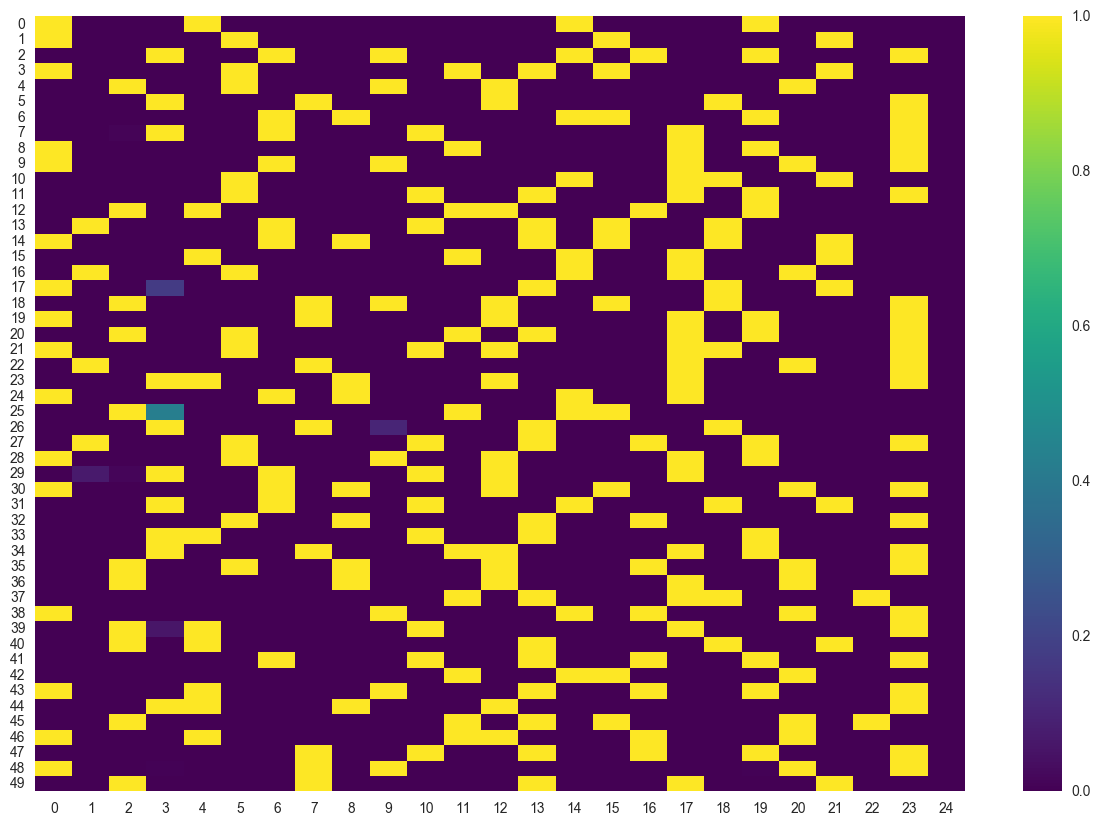

In [70]:

from seaborn import heatmap
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

heatmap(transformed_noisy_validation_data['decoded'][:50,:], annot=False, fmt="g", cmap='viridis')

plt.show()

##### Grid Search for hidden layer accuracy

In [19]:
def evaluate(dims, train, data):
    dsa = DenoisingAutoEncoder(dims=dims, activations=['sigmoid']*len(dims),\
                           noise='mask-0', noise_value=-1, impute=.0, epoch=30000, \
                           lr=0.001, batch_size=100, print_step=1000, mask=0.)
    ##
    dsa.fit_transform(train[(np.random.choice(range(train.shape[0]), train.shape[0]*1.2)),])
    noisy_data = make_impute_data(data, .2)
    data_noisy_transform = dsa.transform(noisy_data)
    imputation_accuracy = (np.round(data_noisy_transform['decoded'])==data).sum()/(data.shape[0]*data.shape[1])
    data_transform = dsa.transform(data)
    reconstruction_accuracy = (np.round(data_transform['decoded'])==data).sum()/(data.shape[0]*data.shape[1])
    ##
    return (imputation_accuracy, reconstruction_accuracy)

In [20]:
dims_grid = [[50, 35, 9], [50, 35], [50], [100], [200], [400], [1000]]

#dims_name_dict = dict(zip(dims_gird, map(lambda a: str(a), dims_grid)))

accuracy_dict = {}

for dims in dims_grid:
    accuracy_dict[str(dims)] = []

In [21]:
accuracy_dict = {}

for key in dims_grid:
    accuracy_dict[str(key)] = []

print(accuracy_dict.keys())

dict_keys(['[100]', '[200]', '[50]', '[400]', '[50, 35, 9]', '[1000]', '[50, 35]'])


##### facing the most riduculous python 'thing' here, automatically sorting list, therefore manually implementing grids

In [22]:
for i in range(8):
    accuracy_dict['[50, 35, 9]'].append(evaluate([50, 35, 9], train, validation))

C:\Users\Neehar\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Instructions for updating:
Use `tf.global_variables_initializer` instead.
0  cost 0.610634
1000  cost 0.25799
2000  cost 0.20848
3000  cost 0.170649
4000  cost 0.164847
5000  cost 0.133638
6000  cost 0.124838
7000  cost 0.114788
8000  cost 0.107961
9000  cost 0.128715
10000  cost 0.105817
11000  cost 0.0890359
12000  cost 0.108183
13000  cost 0.0665122
14000  cost 0.0625116
15000  cost 0.0702066
16000  cost 0.0628266
17000  cost 0.0682947
18000  cost 0.0763787
19000  cost 0.0966896
20000  cost 0.0729901
21000  cost 0.0757215
22000  cost 0.0573166
lr prev 0.001
lr new 0.0003333333333333333
23000  cost 0.082931
24000  cost 0.0752221
25000  cost 0.0752885
26000  cost 0.0636857
27000  cost 0.0533054
28000  cost 0.0603016
29000  cost 0.0603145
Instructions for updating:
Use `tf.global_variables_initializer` instead.
0  cost 0.607074
1000  cost 0.275304
2000  cost 0.21703
3000  cost 0.182348
4000  cost 0.168746
5000  cost 0.157501
6000  cost 0.133489
7000  cost 0.124384
8000  cost 0.114257
9

In [23]:
for i in range(8):
    accuracy_dict['[50, 35]'].append(evaluate([50, 35], train, validation))

C:\Users\Neehar\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Instructions for updating:
Use `tf.global_variables_initializer` instead.
0  cost 0.62987
1000  cost 0.0712709
2000  cost 0.0323934
3000  cost 0.0178395
4000  cost 0.0107381
5000  cost 0.0066158
6000  cost 0.00403927
7000  cost 0.00252748
8000  cost 0.00153719
9000  cost 0.00101455
10000  cost 0.000648483
11000  cost 0.000425936
12000  cost 0.000267428
13000  cost 0.00016033
14000  cost 0.000114733
15000  cost 6.92611e-05
16000  cost 4.38821e-05
17000  cost 2.8111e-05
18000  cost 1.73344e-05
19000  cost 1.20594e-05
20000  cost 7.21087e-06
21000  cost 5.02652e-06
22000  cost 3.16298e-06
lr prev 0.001
lr new 0.0003333333333333333
23000  cost 2.5111e-06
24000  cost 2.04262e-06
25000  cost 1.66077e-06
26000  cost 1.44931e-06
27000  cost 1.1947e-06
28000  cost 9.81205e-07
29000  cost 8.11466e-07
Instructions for updating:
Use `tf.global_variables_initializer` instead.
0  cost 0.679461
1000  cost 0.186869
2000  cost 0.0387553
3000  cost 0.0198784
4000  cost 0.0112655
5000  cost 0.00658738
60

In [24]:
for i in range(8):
    accuracy_dict['[50]'].append(evaluate([50], train, validation))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


C:\Users\Neehar\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0  cost 0.501058
1000  cost 0.0311365
2000  cost 0.0134586
3000  cost 0.00752096
4000  cost 0.00419321
5000  cost 0.00278871
6000  cost 0.00166219
7000  cost 0.00107245
8000  cost 0.00068498
9000  cost 0.000470898
10000  cost 0.000303122
11000  cost 0.000197397
12000  cost 0.000116218
13000  cost 8.1641e-05
14000  cost 5.25638e-05
15000  cost 3.58793e-05
16000  cost 2.49823e-05
17000  cost 1.43676e-05
18000  cost 1.03387e-05
19000  cost 7.17508e-06
20000  cost 4.29687e-06
21000  cost 3.17564e-06
22000  cost 2.07486e-06
lr prev 0.001
lr new 0.0003333333333333333
23000  cost 1.62446e-06
24000  cost 1.35058e-06
25000  cost 1.20292e-06
26000  cost 1.06743e-06
27000  cost 7.9102e-07
28000  cost 7.66935e-07
29000  cost 6.67551e-07
Instructions for updating:
Use `tf.global_variables_initializer` instead.
0  cost 0.554351
1000  cost 0.0364709
2000  cost 0.0149994
3000  cost 0.00819785
4000  cost 0.00485918
5000  cost 0.00302707
6000  cost 0.00182968
7000  cost 0.00113728
8000  cost 0.000749923

In [25]:
for i in range(8):
    accuracy_dict['[100]'].append(evaluate([100], train, validation))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


C:\Users\Neehar\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0  cost 0.62505
1000  cost 0.00448739
2000  cost 0.001922
3000  cost 0.00113074
4000  cost 0.000659721
5000  cost 0.000419376
6000  cost 0.000261414
7000  cost 0.00016011
8000  cost 0.000100759
9000  cost 6.80696e-05
10000  cost 4.27955e-05
11000  cost 2.60914e-05
12000  cost 1.49476e-05
13000  cost 1.05265e-05
14000  cost 6.39657e-06
15000  cost 3.61484e-06
16000  cost 2.4616e-06
17000  cost 1.48836e-06
18000  cost 9.63301e-07
19000  cost 6.03953e-07
20000  cost 3.73996e-07
21000  cost 2.57708e-07
22000  cost 1.9418e-07
lr prev 0.001
lr new 0.0003333333333333333
23000  cost 1.50128e-07
24000  cost 1.40849e-07
25000  cost 1.19697e-07
26000  cost 1.04826e-07
27000  cost 9.33915e-08
28000  cost 8.11389e-08
29000  cost 7.96599e-08
Instructions for updating:
Use `tf.global_variables_initializer` instead.
0  cost 0.571301
1000  cost 0.00527489
2000  cost 0.00215472
3000  cost 0.00125319
4000  cost 0.000720314
5000  cost 0.000470704
6000  cost 0.000275451
7000  cost 0.000183814
8000  cost 0.

In [26]:
for i in range(8):
    accuracy_dict['[200]'].append(evaluate([200], train, validation))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


C:\Users\Neehar\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0  cost 0.63508
1000  cost 0.000517155
2000  cost 0.000190707
3000  cost 0.000109741
4000  cost 6.86985e-05
5000  cost 4.749e-05
6000  cost 2.89748e-05
7000  cost 1.94382e-05
8000  cost 1.26346e-05
9000  cost 9.33458e-06
10000  cost 5.91111e-06
11000  cost 4.2728e-06
12000  cost 2.82659e-06
13000  cost 1.85505e-06
14000  cost 1.20341e-06
15000  cost 7.53532e-07
16000  cost 5.61749e-07
17000  cost 3.503e-07
18000  cost 2.44036e-07
19000  cost 1.46783e-07
20000  cost 9.80407e-08
21000  cost 7.37126e-08
22000  cost 5.33031e-08
lr prev 0.001
lr new 0.0003333333333333333
23000  cost 4.59398e-08
24000  cost 3.98021e-08
25000  cost 3.90929e-08
26000  cost 3.36494e-08
27000  cost 2.97959e-08
28000  cost 2.63321e-08
29000  cost 2.32463e-08
Instructions for updating:
Use `tf.global_variables_initializer` instead.
0  cost 0.566768
1000  cost 0.000521401
2000  cost 0.000212248
3000  cost 9.90714e-05
4000  cost 6.70524e-05
5000  cost 4.4258e-05
6000  cost 2.95385e-05
7000  cost 1.89821e-05
8000  co

In [27]:
for i in range(8):
    accuracy_dict['[400]'].append(evaluate([400], train, validation))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


C:\Users\Neehar\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0  cost 0.587983
1000  cost 0.17321
2000  cost 0.172048
3000  cost 0.1755
4000  cost 0.176636
5000  cost 0.176635
6000  cost 0.174356
7000  cost 0.169706
8000  cost 0.175499
9000  cost 1.01761e-05
10000  cost 1.6373e-06
11000  cost 9.80087e-07
12000  cost 4.70802e-07
13000  cost 3.70214e-07
14000  cost 2.46011e-07
15000  cost 1.47744e-07
16000  cost 1.06888e-07
17000  cost 5.99188e-08
18000  cost 4.62933e-08
19000  cost 3.16676e-08
20000  cost 2.18822e-08
21000  cost 1.29974e-08
22000  cost 1.09972e-08
lr prev 0.001
lr new 0.0003333333333333333
23000  cost 8.28674e-09
24000  cost 8.08248e-09
25000  cost 5.67211e-09
26000  cost 6.54743e-09
27000  cost 3.69081e-09
28000  cost 3.72801e-09
29000  cost 2.73131e-09
Instructions for updating:
Use `tf.global_variables_initializer` instead.
0  cost 0.583434
1000  cost 5.81205e-05
2000  cost 1.8524e-05
3000  cost 7.39632e-06
4000  cost 3.03782e-06
5000  cost 2.19626e-06
6000  cost 1.2828e-06
7000  cost 9.68581e-07
8000  cost 5.17925e-07
9000  co

In [28]:
for i in range(8):
    accuracy_dict['[1000]'].append(evaluate([1000], train, validation))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


C:\Users\Neehar\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0  cost 0.558069
1000  cost 0.1755
2000  cost 0.183303
3000  cost 0.18
4000  cost 0.176635
5000  cost 0.178885
6000  cost 0.183303
7000  cost 0.173205
8000  cost 0.173205
9000  cost 0.181108
10000  cost 0.18
11000  cost 0.178885
12000  cost 0.181108
13000  cost 0.183303
14000  cost 0.172046
15000  cost 0.176635
16000  cost 0.167332
17000  cost 0.173205
18000  cost 0.176635
19000  cost 0.18
20000  cost 0.176635
21000  cost 0.184391
22000  cost 0.183303
lr prev 0.001
lr new 0.0003333333333333333
23000  cost 0.175499
24000  cost 0.176635
25000  cost 0.176635
26000  cost 0.168523
27000  cost 0.169706
28000  cost 0.177764
29000  cost 0.18
Instructions for updating:
Use `tf.global_variables_initializer` instead.
0  cost 0.456265
1000  cost 3.35988e-06
2000  cost 1.5969e-06
3000  cost 6.80884e-07
4000  cost 3.49073e-07
5000  cost 2.27444e-07
6000  cost 1.04571e-07
7000  cost 6.6733e-08
8000  cost 5.00619e-08
9000  cost 2.07892e-08
10000  cost 1.58511e-08
11000  cost 9.50261e-09
12000  cost 5.

In [97]:
accuracy_dict

{'[1000]': [(0.89350993377483445, 0.9701986754966887),
  (0.94324503311258279, 1.0),
  (0.91271523178807945, 0.96966887417218539),
  (0.94463576158940399, 1.0),
  (0.94456953642384101, 1.0),
  (0.94662251655629137, 1.0),
  (0.94079470198675497, 1.0),
  (0.90966887417218545, 0.97026490066225168)],
 '[100]': [(0.899205298013245, 1.0),
  (0.89715231788079475, 1.0),
  (0.90000000000000002, 1.0),
  (0.89662251655629144, 1.0),
  (0.8989403973509934, 1.0),
  (0.90132450331125824, 1.0),
  (0.89443708609271522, 1.0),
  (0.89152317880794707, 1.0)],
 '[200]': [(0.93463576158940398, 1.0),
  (0.93337748344370863, 1.0),
  (0.93251655629139074, 1.0),
  (0.9290066225165563, 1.0),
  (0.93443708609271525, 1.0),
  (0.93158940397350998, 1.0),
  (0.92933774834437088, 1.0),
  (0.93483443708609271, 1.0)],
 '[400]': [(0.94258278145695362, 1.0),
  (0.94642384105960264, 1.0),
  (0.94496688741721857, 1.0),
  (0.9429139072847682, 1.0),
  (0.94145695364238413, 1.0),
  (0.94304635761589406, 1.0),
  (0.9443046357615

In [72]:
colnames = []
IA = []
RA = []
for key, val in accuracy_dict.items():
    colnames.append(key)
    IA.append(np.mean([ia[0] for ia in val]))
    RA.append(np.mean([ia[1] for ia in val]))

In [78]:
?accuracy_df.append

In [88]:
accuracy_df = pd.DataFrame(columns=colnames)

accuracy_df=accuracy_df.append(IA)

C:\Users\Neehar\Anaconda3\lib\site-packages\pandas\indexes\api.py:71: RuntimeWarning: unorderable types: str() < int(), sort order is undefined for incomparable objects
  result = result.union(other)


In [98]:
accuracy_df = pd.DataFrame(columns=colnames)
accuracy_df.loc[0] = IA
accuracy_df.loc[1] = RA
accuracy_df.index = ['Imputation Accuracy', 'Reconstruction Accuracy']
accuracy_df.iloc[:,[4, 6, 2, 0, 1, 3, 5]]

[50, 35, 9]  [50, 35]      [50]     [100]     [200]  \
Imputation Accuracy         0.758932  0.856275  0.880571  0.897401  0.932467   
Reconstruction Accuracy     0.873353  0.992575  0.999909  1.000000  1.000000   

                            [400]    [1000]  
Imputation Accuracy      0.943576  0.929470  
Reconstruction Accuracy  1.000000  0.988767

In [30]:
{'[1000]': [(0.89350993377483445, 0.9701986754966887),
  (0.94324503311258279, 1.0),
  (0.91271523178807945, 0.96966887417218539),
  (0.94463576158940399, 1.0),
  (0.94456953642384101, 1.0),
  (0.94662251655629137, 1.0),
  (0.94079470198675497, 1.0),
  (0.90966887417218545, 0.97026490066225168)],
 '[100]': [(0.899205298013245, 1.0),
  (0.89715231788079475, 1.0),
  (0.90000000000000002, 1.0),
  (0.89662251655629144, 1.0),
  (0.8989403973509934, 1.0),
  (0.90132450331125824, 1.0),
  (0.89443708609271522, 1.0),
  (0.89152317880794707, 1.0)],
 '[200]': [(0.93463576158940398, 1.0),
  (0.93337748344370863, 1.0),
  (0.93251655629139074, 1.0),
  (0.9290066225165563, 1.0),
  (0.93443708609271525, 1.0),
  (0.93158940397350998, 1.0),
  (0.92933774834437088, 1.0),
  (0.93483443708609271, 1.0)],
 '[400]': [(0.94258278145695362, 1.0),
  (0.94642384105960264, 1.0),
  (0.94496688741721857, 1.0),
  (0.9429139072847682, 1.0),
  (0.94145695364238413, 1.0),
  (0.94304635761589406, 1.0),
  (0.94430463576158941, 1.0),
  (0.9429139072847682, 1.0)],
 '[50, 35, 9]': [(0.75860927152317881, 0.87741721854304633),
  (0.76205298013245037, 0.86543046357615894),
  (0.76496688741721852, 0.86953642384105956),
  (0.75523178807947022, 0.86701986754966887),
  (0.76403973509933776, 0.88370860927152317),
  (0.7527814569536424, 0.87397350993377487),
  (0.76238410596026485, 0.87384105960264902),
  (0.7513907284768212, 0.87589403973509938)],
 '[50, 35]': [(0.86536423841059606, 0.99198675496688737),
  (0.8596688741721854, 0.9947019867549669),
  (0.85993377483443711, 0.99324503311258283),
  (0.85509933774834435, 0.99211920529801323),
  (0.8510596026490066, 0.99086092715231788),
  (0.8619205298013245, 0.99377483443708614),
  (0.85178807947019863, 0.99324503311258283),
  (0.84536423841059605, 0.99066225165562916)],
 '[50]': [(0.88589403973509939, 1.0),
  (0.88218543046357611, 0.99986754966887414),
  (0.87715231788079473, 1.0),
  (0.87827814569536422, 0.99973509933774829),
  (0.87841059602649008, 1.0),
  (0.88019867549668873, 0.99986754966887414),
  (0.87682119205298015, 0.99986754966887414),
  (0.88562913907284768, 0.99993377483443713)]}

{'[1000]': [(0.8935099337748345, 0.9701986754966887),
  (0.9432450331125828, 1.0),
  (0.9127152317880795, 0.9696688741721854),
  (0.944635761589404, 1.0),
  (0.944569536423841, 1.0),
  (0.9466225165562914, 1.0),
  (0.940794701986755, 1.0),
  (0.9096688741721854, 0.9702649006622517)],
 '[100]': [(0.899205298013245, 1.0),
  (0.8971523178807947, 1.0),
  (0.9, 1.0),
  (0.8966225165562914, 1.0),
  (0.8989403973509934, 1.0),
  (0.9013245033112582, 1.0),
  (0.8944370860927152, 1.0),
  (0.8915231788079471, 1.0)],
 '[200]': [(0.934635761589404, 1.0),
  (0.9333774834437086, 1.0),
  (0.9325165562913907, 1.0),
  (0.9290066225165563, 1.0),
  (0.9344370860927153, 1.0),
  (0.93158940397351, 1.0),
  (0.9293377483443709, 1.0),
  (0.9348344370860927, 1.0)],
 '[400]': [(0.9425827814569536, 1.0),
  (0.9464238410596026, 1.0),
  (0.9449668874172186, 1.0),
  (0.9429139072847682, 1.0),
  (0.9414569536423841, 1.0),
  (0.9430463576158941, 1.0),
  (0.9443046357615894, 1.0),
  (0.9429139072847682, 1.0)],
 '[50, 3

##### Test Accuracy

In [109]:
evaluate([400], train, test)

C:\Users\Neehar\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Instructions for updating:
Use `tf.global_variables_initializer` instead.
0  cost 0.576937
1000  cost 4.49935e-05
2000  cost 1.56693e-05
3000  cost 9.1995e-06
4000  cost 4.1258e-06
5000  cost 2.23619e-06
6000  cost 1.41968e-06
7000  cost 9.24733e-07
8000  cost 4.83211e-07
9000  cost 3.96351e-07
10000  cost 2.4643e-07
11000  cost 1.41399e-07
12000  cost 9.73792e-08
13000  cost 7.53701e-08
14000  cost 4.07442e-08
15000  cost 2.86445e-08
16000  cost 2.1893e-08
17000  cost 1.34477e-08
18000  cost 9.46142e-09
19000  cost 6.95076e-09
20000  cost 3.76093e-09
21000  cost 3.68618e-09
22000  cost 3.16723e-09
lr prev 0.001
lr new 0.0003333333333333333
23000  cost 1.65001e-09
24000  cost 1.54877e-09
25000  cost 1.23062e-09
26000  cost 1.31176e-09
27000  cost 1.25847e-09
28000  cost 1.08483e-09
29000  cost 1.07515e-09


(0.94512396694214873, 1.0)

In [112]:
final_accuracy=pd.DataFrame(columns=['[400]'])
final_accuracy.loc[0]=[0.94512396694214873]
final_accuracy.loc[1]=[1.]
final_accuracy.index = ['Imputation Test Accuracy', 'Reconstruction Test Accuracy']
final_accuracy

[400]
Imputation Test Accuracy      0.945124
Reconstruction Test Accuracy  1.000000